<a href="https://colab.research.google.com/github/sidagarwal-labs/DSBA-6211---Advance-Business-Analytics/blob/main/federalist_ranking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gensim

In [ ]:
!pip install pyLDavis

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, module='jupyter_client.*')

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [ ]:
#now we have all the libaries installed and ignoring warnings
#lets install pandas & matplotlib

import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
#lets read the data and put into dataframe
papers=pd.read_csv("federalist.csv")
papers

,ID,Author,Text
0,1,HAMILTON,To the People of the State of New York: AFTER ...
1,2,JAY,To the People of the State of New York: WHEN t...
2,3,JAY,To the People of the State of New York: IT IS ...
3,4,JAY,To the People of the State of New York: MY LAS...
4,5,JAY,To the People of the State of New York: QUEEN ...
...,...,...,...
80,81,HAMILTON,To the People of the State of New York: LET US...
81,82,HAMILTON,To the People of the State of New York: THE er...
82,83,HAMILTON,To the People of the State of New York: THE ob...
83,84,HAMILTON,To the People of the State of New York: IN THE...


In [ ]:
#lets look at the distribution of authors column
papers['Author'].value_counts()

,count
Author,
HAMILTON,51
MADISON,14
UNKNOWN,12
JAY,5
HAMILTON AND MADISON,3


In [ ]:
#We will remove JAY & Hamilton + Madison due to confusing the model.
#We don't need to know papers written by Jay & papers written by both will be confusing.
papers=papers[papers['Author'].isin(['HAMILTON','MADISON','UNKNOWN'])]
papers['Author'].value_counts()

,count
Author,
HAMILTON,51
MADISON,14
UNKNOWN,12


In [ ]:
#the original order of dataset is labeled by a
#we will sort the papers based on alphabetical order of author
papers=papers.sort_values(by='Author',ignore_index=True)
papers

,ID,Author,Text
0,1,HAMILTON,To the People of the State of New York: AFTER ...
1,84,HAMILTON,To the People of the State of New York: IN THE...
2,59,HAMILTON,To the People of the State of New York: THE na...
3,60,HAMILTON,To the People of the State of New York: WE HAV...
4,61,HAMILTON,To the People of the State of New York: THE mo...
...,...,...,...
72,54,UNKNOWN,To the People of the State of New York: THE ne...
73,55,UNKNOWN,To the People of the State of New York: THE nu...
74,58,UNKNOWN,To the People of the State of New York: THE re...
75,56,UNKNOWN,To the People of the State of New York: THE SE...


In [ ]:
#all the data points start with To the people of New York
#this will confuse the model. Lets remove the starting sentence from the text
papers['Text']=papers['Text'].str.replace('To the People of the State of New York:','')
papers

,ID,Author,Text
0,1,HAMILTON,AFTER an unequivocal experience of the ineffi...
1,84,HAMILTON,IN THE course of the foregoing review of the ...
2,59,HAMILTON,THE natural order of the subject leads us to ...
3,60,HAMILTON,"WE HAVE seen, that an uncontrollable power ov..."
4,61,HAMILTON,THE more candid opposers of the provision res...
...,...,...,...
72,54,UNKNOWN,THE next view which I shall take of the House...
73,55,UNKNOWN,THE number of which the House of Representati...
74,58,UNKNOWN,THE remaining charge against the House of Rep...
75,56,UNKNOWN,THE SECOND charge against the House of Repres...


In [ ]:
#create a function to check the number of features/terms
#check the number of unique words we have
def dim():
  dimensions = len(set(papers['Text'].str.split().explode().values))
  print(f'{dimensions} dimensions in the potential DFM')
dim()

14819 dimensions in the potential DFM


In [ ]:
#lets check the most frequent words/terms
#the top 20 terms
freq=pd.Series(''.join(papers['Text']).split()).value_counts()[:20]
freq

,count
the,15197
of,10806
to,6345
and,4213
in,3831
a,3619
be,3567
that,2485
is,1872
which,1835


In [ ]:
#we notice there are different cases. Lets convert everything to lower case
papers['Text']=papers['Text'].str.lower()
papers['Text'].head()

,Text
0,after an unequivocal experience of the ineffi...
1,in the course of the foregoing review of the ...
2,the natural order of the subject leads us to ...
3,"we have seen, that an uncontrollable power ov..."
4,the more candid opposers of the provision res...


In [ ]:
#check dimensionality now
#this lower case reduced from 14819 to 13629
dim()

13629 dimensions in the potential DFM


In [ ]:
#now we notice the top words are stopwords like "the", "and", "or"
#these are common words. Lets remove them
#we will leverage the nltk library for a pre-defined set of stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop=stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#lets remove the stopwords
papers['Text']=papers['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
papers

,ID,Author,Text
0,1,HAMILTON,unequivocal experience inefficiency subsisting...
1,84,HAMILTON,"course foregoing review constitution, taken no..."
2,59,HAMILTON,"natural order subject leads us consider, place..."
3,60,HAMILTON,"seen, uncontrollable power elections federal g..."
4,61,HAMILTON,candid opposers provision respecting elections...
...,...,...,...
72,54,UNKNOWN,next view shall take house representatives rel...
73,55,UNKNOWN,"number house representatives consist, forms an..."
74,58,UNKNOWN,"remaining charge house representatives, examin..."
75,56,UNKNOWN,"second charge house representatives is, small ..."


In [ ]:
#check dimensionality after removing stopwords
#further goes from 13629 to 13507
dim()

13507 dimensions in the potential DFM


In [ ]:
#lets check the most frequent words again after removing stopwords
freq=pd.Series(''.join(papers['Text']).split()).value_counts()[:20]
freq

,count
would,1160
may,744
state,486
power,455
one,429
must,413
government,412
states,378
upon,378
every,342


In [ ]:
#now lets remove all the puncutation to further reduce dimensionality
papers['Text']=papers['Text'].str.replace(r'[^\w\s]+','',regex=True)

In [ ]:
#again check dimensionality
#further reducing from 13507 to 8424
dim()

8424 dimensions in the potential DFM


In [ ]:
#now lets also do stemming to bring together dog vs dogs
from nltk.stem import PorterStemmer
st=PorterStemmer()
papers['Text']=papers['Text'].apply(lambda x: ' '.join([st.stem(word) for word in x.split()]))

In [ ]:
#again check dimensionality
#further reducing from 8424 to 5022
dim()

5022 dimensions in the potential DFM


In [ ]:
#now again lets look at the top terms frequency
freq=pd.Series(''.join(papers['Text']).split()).value_counts()[:20]
freq

,count
state,1521
would,1198
govern,958
power,853
may,768
constitut,658
nation,489
one,485
peopl,477
must,428


In [ ]:
#we see that terms like "would" and "may" could also be stopwords
#lets create a personalized stopword list
stop +=['would',
       'may',
       'one',
       'must',
       'upon',
       'might',
       'ought',
       'shall',
       'could']

In [ ]:
#lets remove the stop+ from the papers as well
papers['Text']=papers['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [ ]:
#lets create a word cloud
from wordcloud import WordCloud
comment_words=str(''.join(papers['Text']).split())

In [ ]:
#to further clean to remove puncutation and special characters
import string
comment_words=comment_words.translate(str.maketrans('','',string.punctuation))

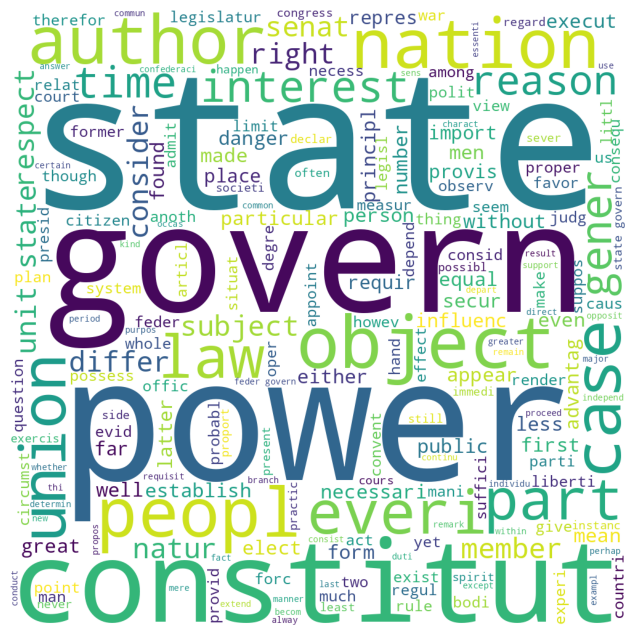

In [ ]:
#create wordcloud based on top 200 words
wordcloud=WordCloud(background_color='white',
                    max_words=200,
                    width=1000,height=1000).generate(comment_words)
plt.figure(figsize=(8,8))
plt.clf()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
#explore analysis with similarity and clustering
#prepare the collection of texts

doc_complete = papers.Text
doc_complete

,Text
0,unequivoc experi ineffici subsist feder govern...
1,cours forego review constitut taken notic ende...
2,natur order subject lead us consid place provi...
3,seen uncontrol power elect feder govern withou...
4,candid oppos provis respect elect contain plan...
...,...
72,next view take hous repres relat appoint membe...
73,number hous repres consist form anoth interest...
74,remain charg hous repres examin ground supposi...
75,second charg hous repres small possess due kno...


In [ ]:
#tokenize each document
corpus = [doc.split() for doc in doc_complete]
corpus

[['unequivoc',
  'experi',
  'ineffici',
  'subsist',
  'feder',
  'govern',
  'call',
  'deliber',
  'new',
  'constitut',
  'unit',
  'state',
  'america',
  'subject',
  'speak',
  'import',
  'comprehend',
  'consequ',
  'noth',
  'less',
  'exist',
  'union',
  'safeti',
  'welfar',
  'part',
  'compos',
  'fate',
  'empir',
  'mani',
  'respect',
  'interest',
  'world',
  'frequent',
  'remark',
  'seem',
  'reserv',
  'peopl',
  'countri',
  'conduct',
  'exampl',
  'decid',
  'import',
  'question',
  'whether',
  'societi',
  'men',
  'realli',
  'capabl',
  'establish',
  'good',
  'govern',
  'reflect',
  'choic',
  'whether',
  'forev',
  'destin',
  'depend',
  'polit',
  'constitut',
  'accid',
  'forc',
  'truth',
  'remark',
  'crisi',
  'arriv',
  'proprieti',
  'regard',
  'era',
  'decis',
  'made',
  'wrong',
  'elect',
  'part',
  'act',
  'view',
  'deserv',
  'consid',
  'gener',
  'misfortun',
  'mankind',
  'idea',
  'add',
  'induc',
  'philanthropi',
  'patr

In [ ]:
#create our own term dictionary
from gensim import corpora, models
dictionary = corpora.Dictionary(corpus)

In [ ]:
#filter out extreme tokens, very rare and very frequent terms
#less than no_below documents (absolute number)
#more than no_above documents (fraction of corpus size, not absolute number)

dictionary.filter_extremes(no_below=2, no_above=0.75)

In [ ]:
#converting the list of documents (corpus) into Document Term Matrix
#Using dictionary prepared above
DFM = [dictionary.doc2bow(doc) for doc in corpus]

In [ ]:
#frequency of individual words in each document, not very human readable
print(DFM)

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 3), (13, 1), (14, 1), (15, 1), (16, 2), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 1), (24, 1), (25, 3), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 2), (36, 1), (37, 3), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 2), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 2), (59, 1), (60, 3), (61, 1), (62, 1), (63, 2), (64, 1), (65, 1), (66, 1), (67, 2), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 2), (77, 1), (78, 2), (79, 1), (80, 1), (81, 1), (82, 1), (83, 3), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 2), (90, 1), (91, 2), (92, 1), (93, 1), (94, 1), (95, 2), (96, 2), (97, 1), (98, 1), (99, 3), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 2), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1)

In [ ]:
#number of documents, rows
len(DFM)

77

In [ ]:
#show the token id and associated word
print(dictionary.token2id)

{'1': 0, 'abl': 1, 'absurd': 2, 'accid': 3, 'accordingli': 4, 'acknowledg': 5, 'act': 6, 'actuat': 7, 'add': 8, 'addit': 9, 'address': 10, 'admit': 11, 'adopt': 12, 'advantag': 13, 'adversari': 14, 'advoc': 15, 'affect': 16, 'afford': 17, 'aggrand': 18, 'aim': 19, 'allow': 20, 'alreadi': 21, 'altern': 22, 'alway': 23, 'ambigu': 24, 'ambit': 25, 'ambiti': 26, 'america': 27, 'among': 28, 'amus': 29, 'analog': 30, 'animos': 31, 'anoth': 32, 'answer': 33, 'antagonist': 34, 'apt': 35, 'ardent': 36, 'argument': 37, 'arriv': 38, 'artific': 39, 'astray': 40, 'attain': 41, 'attempt': 42, 'attend': 43, 'attent': 44, 'avaric': 45, 'avow': 46, 'awar': 47, 'bait': 48, 'begin': 49, 'begun': 50, 'bia': 51, 'bitter': 52, 'breast': 53, 'call': 54, 'candor': 55, 'capabl': 56, 'career': 57, 'caus': 58, 'caution': 59, 'certain': 60, 'chang': 61, 'character': 62, 'choic': 63, 'circl': 64, 'circumst': 65, 'claim': 66, 'class': 67, 'clearli': 68, 'collect': 69, 'commenc': 70, 'commonli': 71, 'compos': 72, 'c

In [ ]:
#check the number of terms
len(dictionary.token2id)

3228

In [ ]:
#compute similarity between documents
#distance is 1-similarity

from gensim.similarities import MatrixSimilarity
simil = MatrixSimilarity(DFM, num_features=len(dictionary))
distance = 1 - simil[DFM]

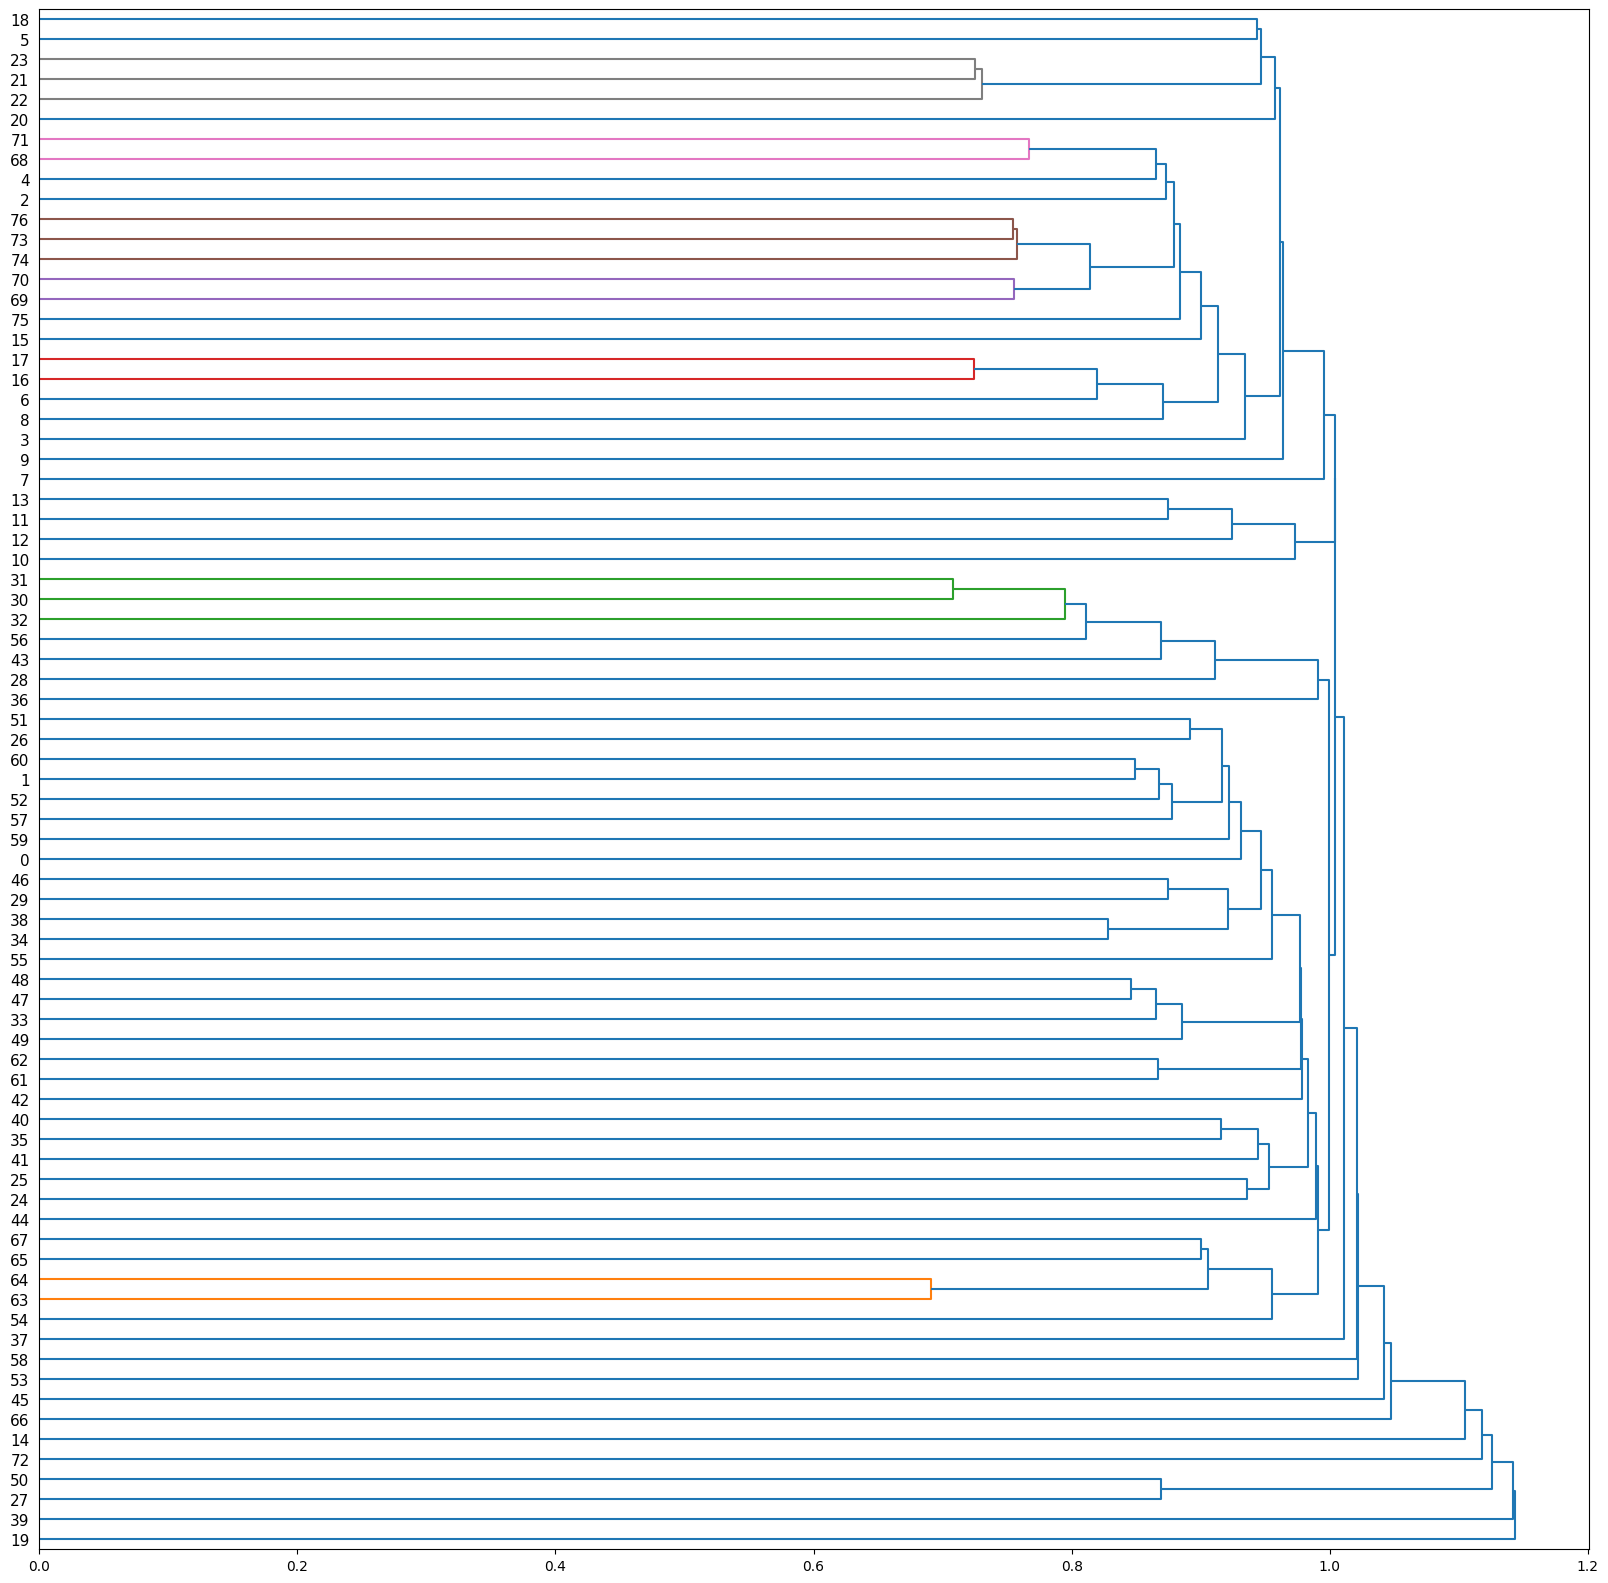

In [ ]:
#now lets run hierarchical clustering
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt

Z = hierarchy.linkage(distance, 'single')
plt.figure(figsize=(20, 20))

dn = hierarchy.dendrogram(Z,
                          orientation='right',
                          labels=papers.index,
                          leaf_font_size=11)
plt.show()

In [ ]:
#most similar to document 7?
text_sim = pd.DataFrame(simil[DFM])
text_sim[76].sort_values(ascending=False)

,76
76,1.000000
73,0.551241
74,0.509555
75,0.482480
69,0.467292
...,...
7,0.134518
39,0.132012
50,0.122683
27,0.115211


In [ ]:
#view overall matrix
text_sim

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76
0,1.000000,0.375197,0.228101,0.280636,0.252490,0.265837,0.208353,0.137888,0.167403,0.149976,0.305684,0.293697,0.245818,0.299596,0.205554,0.186615,0.216414,0.237323,0.307600,0.203864,0.232164,0.224800,0.150821,0.246407,0.240929,0.251709,0.403091,0.232721,0.252066,0.253019,0.329420,0.264851,0.260670,0.282399,0.322333,0.217006,0.237089,0.270583,0.343009,0.261081,0.233063,0.217629,0.298778,0.266161,0.315171,0.238316,0.268385,0.238231,0.285343,0.314458,0.122117,0.379947,0.306060,0.220996,0.367799,0.213763,0.339213,0.207088,0.272236,0.325467,0.249685,0.297753,0.325833,0.111463,0.197461,0.287410,0.177400,0.277594,0.223339,0.273801,0.277512,0.201278,0.206332,0.236872,0.226086,0.152679,0.234079
1,0.375197,1.000000,0.305863,0.279309,0.297993,0.311970,0.297556,0.254416,0.244816,0.348126,0.292808,0.307949,0.250488,0.320844,0.244081,0.306771,0.262726,0.351813,0.409015,0.275620,0.281395,0.264511,0.182450,0.319547,0.346567,0.273749,0.408063,0.344118,0.292217,0.253959,0.381300,0.311361,0.383356,0.307527,0.380270,0.333801,0.296108,0.248629,0.356355,0.204450,0.273443,0.233477,0.256844,0.257542,0.318391,0.201347,0.242083,0.300287,0.326427,0.328550,0.317526,0.264279,0.455086,0.298080,0.326857,0.360371,0.368103,0.367377,0.301028,0.412759,0.477520,0.333587,0.328891,0.194777,0.212440,0.301833,0.172669,0.312062,0.320047,0.297255,0.293907,0.294430,0.288728,0.326621,0.319594,0.296511,0.335679
2,0.228101,0.305863,1.000000,0.428781,0.452011,0.294031,0.394952,0.290509,0.377190,0.239130,0.275796,0.273003,0.263505,0.274291,0.154371,0.377725,0.301664,0.385942,0.264357,0.236504,0.204563,0.185042,0.107763,0.197570,0.288000,0.218817,0.256782,0.195915,0.199102,0.295177,0.258442,0.255911,0.200527,0.292340,0.319885,0.227973,0.194491,0.240390,0.296709,0.171601,0.190734,0.177804,0.242093,0.192243,0.215054,0.176523,0.274063,0.223807,0.273078,0.255967,0.210013,0.258109,0.309625,0.365889,0.258707,0.259082,0.296323,0.283724,0.230650,0.270814,0.308599,0.318550,0.289056,0.180070,0.188139,0.245214,0.263547,0.214834,0.416462,0.482038,0.391335,0.384597,0.222816,0.341474,0.358344,0.273300,0.357561
3,0.280636,0.279309,0.428781,1.000000,0.411323,0.266186,0.326804,0.182590,0.344885,0.226208,0.267836,0.282009,0.276218,0.292821,0.213646,0.281801,0.267084,0.345736,0.256809,0.147843,0.252864,0.199075,0.128542,0.214199,0.363275,0.394025,0.274650,0.192893,0.243715,0.318627,0.261239,0.247041,0.224304,0.236634,0.300774,0.292063,0.209471,0.269684,0.297923,0.178274,0.315225,0.271773,0.254111,0.221788,0.307428,0.214442,0.294096,0.212245,0.229225,0.263188,0.172478,0.271343,0.320517,0.247251,0.356245,0.183406,0.254290,0.247182,0.235564,0.285709,0.293210,0.298729,0.345864,0.146698,0.202715,0.242897,0.214888,0.245158,0.369303,0.380080,0.320465,0.319332,0.331213,0.289753,0.310019,0.263262,0.398525
4,0.252490,0.297993,0.452011,0.411323,1.000000,0.259915,0.283716,0.182712,0.325281,0.216918,0.240092,0.260884,0.186084,0.270352,0.138051,0.268017,0.250751,0.275554,0.247818,0.234321,0.195030,0.204891,0.106939,0.207480,0.303816,0.222588,0.302924,0.185075,0.228124,0.227117,0.284591,0.245091,0.228337,0.213181,0.240370,0.231620,0.194460,0.200507,0.245044,0.137855,0.140684,0.171011,0.243048,0.175895,0.212924,0.148912,0.248737,0.185176,0.176038,0.181605,0.145632,0.258751,0.279395,0.304772,0.234642,0.252625,0.270076,0.210360,0.234967,0.285932,0.272550,0.294317,0.312500,0.173611,0.175186,0.233665,0.261235,0.147926,0.448846,0.408939,0.304924,0.427909,0.210117,0.334916,0.321906,0.299343,0.447637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [ ]:
#to check for word similarity
from gensim.models import Word2Vec
model = Word2Vec(corpus, min_count=20, workers = 3, window = 3, sg = 1)

In [ ]:
#check for most similar word to "commerc"
model.wv.most_similar('commerc', topn=10)

[('trade', 0.9924299120903015),
 ('prevent', 0.992102324962616),
 ('product', 0.9920600652694702),
 ('affair', 0.9916223287582397),
 ('friend', 0.991361677646637),
 ('mutual', 0.9913476705551147),
 ('engag', 0.9913400411605835),
 ('variou', 0.9912991523742676),
 ('enterpris', 0.9912662506103516),
 ('foreign', 0.9910825490951538)]

In [ ]:
#check for most similar word to "war"
model.wv.most_similar('war', topn=10)

[('resourc', 0.9926194548606873),
 ('long', 0.9920645356178284),
 ('occas', 0.9919376373291016),
 ('jealousi', 0.991098940372467),
 ('friend', 0.9909389615058899),
 ('safeti', 0.9907351136207581),
 ('mankind', 0.9906916618347168),
 ('ambit', 0.9906827807426453),
 ('enterpris', 0.9906497001647949),
 ('europ', 0.9906209111213684)]

In [ ]:
#topic modeling using LDA
#this can only be implemented after the dictionary and feature
n_topics = 8
ldamodel = models.LdaModel(DFM,
                            num_topics=n_topics,
                            id2word=dictionary,
                            passes=40)

In [ ]:
#print the topic model
print(ldamodel.print_topics(num_topics=n_topics, num_words=10))

[(0, '0.008*"armi" + 0.007*"peac" + 0.007*"liberti" + 0.007*"provis" + 0.007*"legisl" + 0.007*"establish" + 0.006*"forc" + 0.005*"right" + 0.005*"period" + 0.005*"militari"'), (1, '0.018*"depart" + 0.017*"court" + 0.015*"legisl" + 0.012*"presid" + 0.012*"appoint" + 0.011*"offic" + 0.010*"senat" + 0.010*"judiciari" + 0.008*"suprem" + 0.006*"magistr"'), (2, '0.006*"war" + 0.005*"countri" + 0.004*"situat" + 0.004*"establish" + 0.004*"confederaci" + 0.004*"armi" + 0.004*"necess" + 0.004*"forc" + 0.004*"system" + 0.003*"commerc"'), (3, '0.011*"citizen" + 0.009*"right" + 0.009*"confeder" + 0.009*"foreign" + 0.008*"articl" + 0.007*"regul" + 0.006*"treati" + 0.005*"establish" + 0.005*"jurisdict" + 0.005*"provis"'), (4, '0.023*"juri" + 0.018*"trial" + 0.015*"court" + 0.011*"caus" + 0.009*"plan" + 0.007*"militia" + 0.007*"civil" + 0.007*"jurisdict" + 0.006*"matter" + 0.006*"provis"'), (5, '0.008*"offic" + 0.007*"claus" + 0.007*"tax" + 0.007*"man" + 0.006*"duti" + 0.006*"articl" + 0.006*"taxat" +

In [ ]:
#visualize the LDA result
import pyLDAvis
pyLDAvis.enable_notebook()

import pyLDAvis.gensim_models
vis=pyLDAvis.gensim_models.prepare(ldamodel, DFM, dictionary)
vis

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.004753  0.027649       1        1  26.718557
2     -0.091342 -0.009149       2        1  23.733753
1      0.133584  0.037366       3        1  13.192058
7      0.003683  0.035363       4        1  10.465664
5      0.026241  0.071722       5        1   9.366609
3      0.028870 -0.120364       6        1   5.764715
4      0.006953 -0.078318       7        1   5.565383
0     -0.103237  0.035730       8        1   5.193262, topic_info=         Term        Freq       Total Category  logprob  loglift
92      court  204.000000  204.000000  Default  30.0000  30.0000
654      juri   76.000000   76.000000  Default  29.0000  29.0000
529    depart  161.000000  161.000000  Default  28.0000  28.0000
876     trial   85.000000   85.000000  Default  27.0000  27.0000
666    legisl  237.000000  237.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
684    measur    9.577907  111.417699   Topic8  -5.7147   0.5040
910    within    9.351549  109.464372   Topic8  -5.7386   0.4978
514   council    9.144126  110.334171   Topic8  -5.7610   0.4674
642   instanc    9.145022  111.803715   Topic8  -5.7609   0.4543
65   circumst    8.887452  129.084683   Topic8  -5.7895   0.2820

[605 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
3213      8  0.761458    1784
2399      1  0.273056  abolit
2399      4  0.136528  abolit
2399      7  0.546111  abolit
2909      2  0.865238  abroad
...     ...       ...     ...
915       3  0.170882    year
915       4  0.040208    year
915       6  0.030156    year
915       7  0.010052    year
915       8  0.100519    year

[1892 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 3, 2, 8, 6, 4, 5, 1])

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
#predict authorship using SVD (single value dimension model)
#apply TF-IDF to adjust weight of doc term matrix
tfidf = models.TfidfModel(DFM)
DFM_tfidf = tfidf[DFM]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [ ]:
#Apply SVD and keep 9 dimensions
n_SVD = 9
SVD_model = models.LsiModel(DFM_tfidf,
                            id2word=dictionary,
                            num_topics=n_SVD)
SVD = SVD_model[DFM_tfidf]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [ ]:
#Convert results into Array
import gensim
svd_array = gensim.matutils.corpus2csc(SVD).T.toarray()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [ ]:
#convert the results into data frame
svd_df = pd.DataFrame(svd_array)
svd_df

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

,0,1,2,3,4,5,6,7,8
0,0.321852,-0.069569,0.028002,-0.080855,0.061758,-0.126187,0.025516,-0.025054,0.172106
1,0.408479,0.021046,0.014757,0.157750,-0.147835,0.167682,-0.180213,0.035906,0.015036
2,0.375396,0.053808,-0.184974,0.036947,-0.050731,0.069975,0.023191,0.045403,0.206944
3,0.372924,-0.032445,-0.126490,0.113266,0.103914,-0.012353,0.264669,-0.022035,0.129177
4,0.306820,-0.015172,-0.172512,0.037848,0.191523,0.244457,0.050432,0.031184,0.144899
...,...,...,...,...,...,...,...,...,...
72,0.230264,-0.050129,-0.061617,0.157501,0.158711,0.001317,0.076583,0.137682,0.045438
73,0.339683,-0.040141,-0.212549,0.022709,0.275179,0.312335,-0.037251,0.020076,-0.025860
74,0.383350,0.023821,-0.219557,-0.005472,0.202397,0.062304,0.006219,0.145915,0.082570
75,0.291245,-0.118570,-0.090528,0.167709,0.373519,0.316845,-0.022344,-0.135492,-0.070289


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
#prepare DF for predicitive models
model_df = pd.concat([papers.reset_index()['Author'], svd_df],
                     axis = 1, ignore_index = True).rename({0:'Author'},
                                                           axis = 1)
model_df

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

,Author,1,2,3,4,5,6,7,8,9
0,HAMILTON,0.321852,-0.069569,0.028002,-0.080855,0.061758,-0.126187,0.025516,-0.025054,0.172106
1,HAMILTON,0.408479,0.021046,0.014757,0.157750,-0.147835,0.167682,-0.180213,0.035906,0.015036
2,HAMILTON,0.375396,0.053808,-0.184974,0.036947,-0.050731,0.069975,0.023191,0.045403,0.206944
3,HAMILTON,0.372924,-0.032445,-0.126490,0.113266,0.103914,-0.012353,0.264669,-0.022035,0.129177
4,HAMILTON,0.306820,-0.015172,-0.172512,0.037848,0.191523,0.244457,0.050432,0.031184,0.144899
...,...,...,...,...,...,...,...,...,...,...
72,UNKNOWN,0.230264,-0.050129,-0.061617,0.157501,0.158711,0.001317,0.076583,0.137682,0.045438
73,UNKNOWN,0.339683,-0.040141,-0.212549,0.022709,0.275179,0.312335,-0.037251,0.020076,-0.025860
74,UNKNOWN,0.383350,0.023821,-0.219557,-0.005472,0.202397,0.062304,0.006219,0.145915,0.082570
75,UNKNOWN,0.291245,-0.118570,-0.090528,0.167709,0.373519,0.316845,-0.022344,-0.135492,-0.070289


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
#Context specific data partition
#No validation dataset due to small sample
testData = model_df[(model_df['Author'] == 'UNKNOWN')]
trainData = model_df[~(model_df['Author'] == 'UNKNOWN')]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [ ]:
# Manually dummy code the target variable, Author
trainData['Author'] = [0 if x == 'HAMILTON' else 1 for x in trainData.Author]

/tmp/ipython-input-3038119876.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainData['Author'] = [0 if x == 'HAMILTON' else 1 for x in trainData.Author]


In [ ]:
# Manually create DV and IV for train and test datasets
y_train = trainData['Author']
X_train = trainData[trainData.columns[trainData.columns != 'Author']]
X_test = testData[testData.columns[testData.columns != 'Author']]

In [ ]:
y_train.value_counts()

,count
Author,
0,51
1,14


In [ ]:
#import a decision tree model
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [ ]:
tree_predictions = tree.predict(X_test)
tree_predictions

array([1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0])

In [ ]:
#this is the score for the decision tree
tree.score(X_train, y_train)

1.0

In [ ]:
#import logistic regression model to run over the dataset
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(class_weight = 'balanced')
LR.fit(X_train, y_train)
lr_predictions = LR.predict(X_test)
lr_predictions

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:451: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  opt_res = optimize.minimize(


array([1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0])

In [ ]:
#this is the log reg score
LR.score(X_train, y_train)

0.9076923076923077

In [ ]:
#this is comparing the log reg vs tree ouputs for index items 0-11
results = pd.DataFrame(lr_predictions, columns = ['SKlearn LR'])
results['Tree'] = tree_predictions
results

,SKlearn LR,Tree
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
5,0,0
6,1,1
7,0,0
8,1,1
9,1,0


In [ ]:
#this is the model outputs comparing for the unknown items index values
doc_labels = list(range(65,77))
results.index = doc_labels

In [ ]:
results

,SKlearn LR,Tree
65,1,1
66,1,1
67,1,1
68,1,1
69,1,1
70,0,0
71,1,1
72,0,0
73,1,1
74,1,0
